In [1]:
import logging
logging.getLogger('trimesh').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('matplotlib').setLevel(logging.CRITICAL)
import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
from pvtrace import *

# Light sources

Light sources are **generators** of rays. They are useful to sample spatial, angular or spectral properties of rays automatically.

Make a default light object (with no arguments) emits rays as:
 * vertically, direction = (0, 0, 1)
 * from origin, position = (0, 0, 0)
 * wavelength = 555nm
 
this is somewhat similar to a laser.

In [2]:
light = Light()
list(light.emit(1))

[Ray(pos=(0.00, 0.00, 0.00), dir=(0.00, 0.00, 1.00), nm=555.00, alive=True)]

Note that the `emit` method is a Python generator so to get out the value it needs to be iterated.

## Sampling directions

Supply a `phase_function` to sample angular ranges,

```python
Light(direction=isotropic)
Light(direction=lambertian)
```

Some phase functions takes arguments, such as `cone(half_angle)`,

```python
Light(direction=functools.partial(cone, np.pi/8))
```

In [29]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Material(refractive_index=1.0)
    )
)
scene = Scene(world)
light = Light(
    direction=functools.partial(cone, np.pi/4)
)
vis = MeshcatRenderer()
vis.render(scene)
for ray in light.emit(100):
    steps = photon_tracer.follow(scene, ray)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7030/static/


## Samping positions

A spatial mask defines allowed locations from which rays can be generated.

```python
Light(position=functools.partial(rectangular_mask, 1, 1))  # half side-length (x, y)
Light(position=functools.partial(cube_mask, 1, 1, 1))  # half side-length (x, y, z)
Light(position=functools.partial(circular_mask, 1))  # radius of the circle
```

`functools.partial` is used because these take arguments.

In [32]:
# Square emitter
light = Light(direction=lambertian, position=functools.partial(rectangular_mask, 1, 1))
vis = MeshcatRenderer()
vis.render(scene)
for ray in light.emit(500):
    steps = photon_tracer.follow(scene, ray)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
vis.vis.jupyter_cell()

NameError: name 'lambertian' is not defined

## Any combination of position and divergence

The power of the delegate approach is that, the angular and position delegates are independent, meaning that any combination is allowed and trivial to configure. In the example below we have used a cone divergence with a square mask

```python
Light(
    position=position=functools.partial(square_mask, 1, 0.3),
    direction=lambertian
)
```

## Sampling a spectrum

To sample wavelength from a spectrum use a `Distribution` object.

Let's make an emission spectrum based on a Gaussian centred at 600nm. If you have experimental data you could import it as x, y column and use that instead.

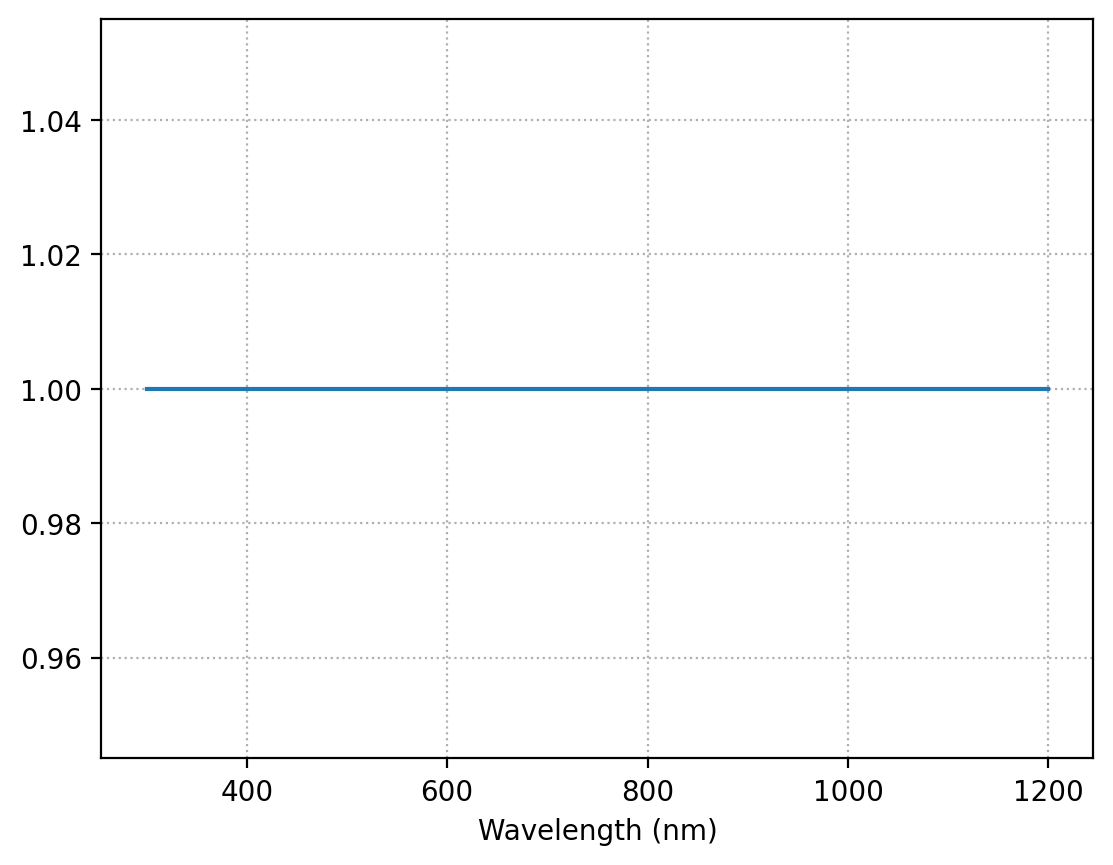

In [36]:
def make_emission_spectrum(wavelengths):
    return np.exp(-((wavelengths-800.0)/300.0)**2)
x = np.linspace(300, 1200)
# y = np.exp(-((x-800.0)/300.0)**2)
y = np.ones(50)
plt.plot(x, y)
plt.xlabel('Wavelength (nm)')
plt.grid(linestyle='dotted')
plt.show()

In [37]:
dist = Distribution(x, y)
dist.sample(np.random.uniform())
light = Light(
    wavelength=lambda: dist.sample(np.random.uniform())
)

Emit 10000 rays and plot a histogram of the distribution of wavelengths against the input.

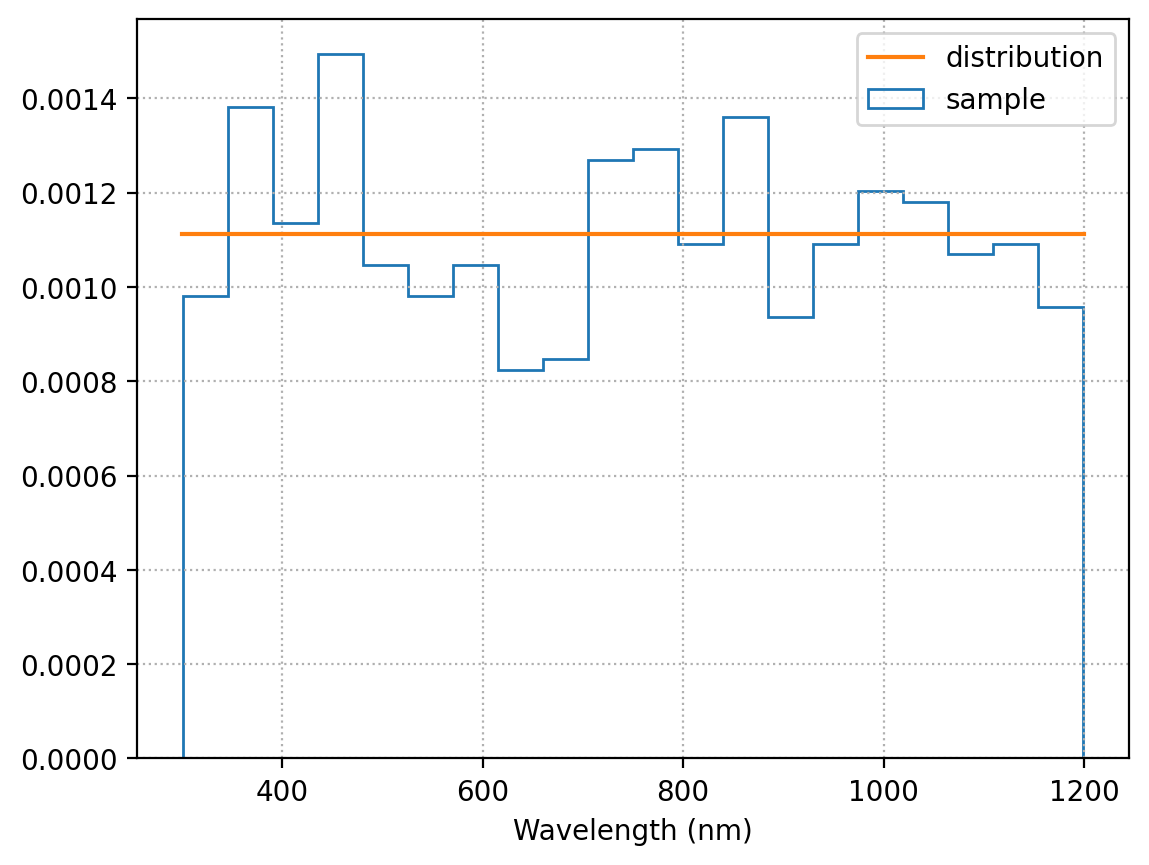

In [51]:
plt.hist([x.wavelength for x in list(light.emit(1000))], bins=20, density=True, histtype='step', label='sample')
plt.plot(x, y/np.trapz(y, x), label='distribution')
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.grid(linestyle='dotted')
plt.show()